In [1]:
from matplotlib import pyplot as plt
from matplotlib import patches
from scipy.stats import norm
import numpy as np
plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{dsfont}')

In [2]:
target_color = "#89B352"
critic_color = "#ff4500"
approx_color = "#1C71A6"
lmbda_color = "#ba55d3"
ks_color = "#dc143c"

rng = np.random.RandomState(1000)

In [3]:
def mixture_density_pdf(x, config):
    return np.stack([c["weight"] * norm.pdf(x, loc=c["loc"], scale=c["scale"]) for c in config], axis=0).sum(axis=0)

def mixture_density_sample(n, config, rng=rng):
    samples = np.stack([norm.rvs(size=n, loc=c["loc"], scale=c["scale"], random_state=rng) for c in config], axis=0)
    index = rng.choice(len(config), size=n, p=tuple(c["weight"] for c in config))
    return np.array([s[i] for s, i in zip(samples.T, index)])

target_density_config = (
    {"weight": 0.8, "loc": 0, "scale": 1.0},
    {"weight": 0.15, "loc": 4.0, "scale": 0.5},
    {"weight": 0.05, "loc": 5.0, "scale": 0.25}
)

approx_density_config = (
    {"weight": 0.5, "loc": 2.0, "scale": 1.0},
    {"weight": 0.45, "loc": 5.0, "scale": 0.5},
    {"weight": 0.05, "loc": 7.0, "scale": 0.25}
)

critic_density_config = (
    {"weight": 0.85, "loc": -0.4, "scale": 0.5},
    {"weight": 0.1, "loc": 3.2, "scale": 0.5},
    {"weight": 0.05, "loc": 6.0, "scale": 0.35}
)

def target_density(x):
    return mixture_density_pdf(x, target_density_config)

def approx_density(x):
    return mixture_density_pdf(x, approx_density_config)

def critic(x):
    critic_density = mixture_density_pdf(x, critic_density_config)
    return -np.log(critic_density)/70-0.15

In [4]:
x = np.linspace(-3.3, 8., 1000)
n = 15
lmbda = -0.08

target_samples = mixture_density_sample(n, target_density_config)
approx_samples = mixture_density_sample(n, approx_density_config)

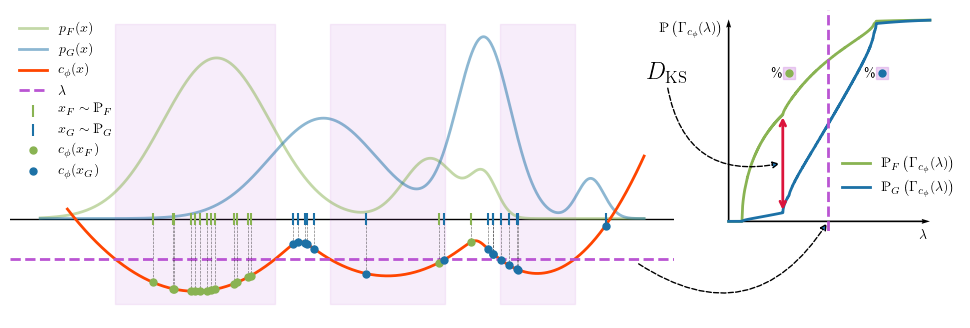

In [5]:
fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1.]})
ax = axs[0]
ax.plot(x, target_density(x), c=target_color, zorder=2, lw=2, alpha=0.5, label=r"$p_F(x)$")
ax.plot(x, approx_density(x), c=approx_color, zorder=2, lw=2, alpha=0.5, label=r"$p_G(x)$")
ax.plot(x[45:], critic(x[45:]), c=critic_color, zorder=2, lw=2, label=r"$c_{\phi}(x)$")
ax.axhline(0, c="black", zorder=1, lw=1)
ax.axhline(lmbda, c=lmbda_color, ls="--", lw=2, zorder=2, label=r"$\lambda$")

ax.scatter(target_samples, np.zeros_like(target_samples), color=target_color, marker='|', s=75, zorder=3, label=r"$x_F \sim \mathds{P}_F$")
ax.scatter(approx_samples, np.zeros_like(approx_samples), color=approx_color, marker='|', s=75, zorder=3, label=r"$x_G \sim \mathds{P}_G$")

ax.scatter(target_samples, critic(target_samples), color=target_color, marker='o', s=25, zorder=3, label=r"$c_{\phi}(x_F)$")
ax.scatter(approx_samples, critic(approx_samples), color=approx_color, marker='o', s=25, zorder=3, label=r"$c_{\phi}(x_G)$")
ax.plot(
    np.vstack((target_samples, target_samples)),
    np.vstack((np.zeros_like(target_samples), critic(target_samples))),
    ls='--', lw=0.5, alpha=0.5, color="black",
)
ax.plot(
    np.vstack((approx_samples, approx_samples)),
    np.vstack((np.zeros_like(approx_samples), critic(approx_samples))),
    ls='--', lw=0.5, alpha=0.5, color="black",
)

ymin, ymax = ax.get_ylim()
ax.fill_between(x, where=critic(x) <= lmbda, y1=ymin, y2=ymax, color=lmbda_color, alpha=0.1)
ax.axis('off')
ax.set_anchor("N")
ax.legend(loc="upper left", frameon=False, bbox_to_anchor=[-0.005, 1.], fontsize="medium")

ax = axs[1]
ax.axis('off')

x_coverage = np.linspace(-10, 20, 10000)
critic_score_x_coverage = critic(x_coverage)
target_density_x_coverage = target_density(x_coverage)
approx_density_x_coverage = approx_density(x_coverage)
delta_volume = ((x_coverage[-1]-x_coverage[0])/len(x_coverage))
lmbda_coverage = np.linspace(
    critic_score_x_coverage.min()-1.e-2,
    np.concatenate([critic(target_samples), critic(approx_samples)]).max()+1.e-2,
    5000
)
ax.quiver(lmbda_coverage[0], 0., lmbda_coverage[-1]-lmbda_coverage[0], 0.0, color="black", angles='xy', scale_units='xy', scale=1, linewidth=1, units="xy")
ax.quiver(lmbda_coverage[0], 0., 0.0, 1., color="black", angles='xy', scale_units='xy', scale=1, linewidth=1, units="xy")
ax.text(s=r"$\lambda$", x=lmbda_coverage[-1]-0.005, y=-0.07, color="black",
       verticalalignment="center", horizontalalignment="center", fontsize="medium")
ax.text(s=r"$\mathds{P}\left(\Gamma_{c_{\phi}}(\lambda)\right)$", x=lmbda_coverage[0]-0.028, y=0.95, color="black",
       verticalalignment="center", horizontalalignment="center", fontsize="medium")

ax.plot(
    lmbda_coverage,
    target_coverage := np.array([((critic_score_x_coverage<=lmbda_lvl)*target_density_x_coverage*delta_volume).sum() for lmbda_lvl in lmbda_coverage]),
    color=target_color,
    lw=2,
    label=r"$\mathds{P}_F\left(\Gamma_{c_{\phi}}(\lambda)\right)$"
)
ax.plot(
    lmbda_coverage,
    approx_coverage := np.array([((critic_score_x_coverage<=lmbda_lvl)*approx_density_x_coverage*delta_volume).sum() for lmbda_lvl in lmbda_coverage]),
    color=approx_color,
    lw=2,
        label=r"$\mathds{P}_G\left(\Gamma_{c_{\phi}}(\lambda)\right)$"
)
ax.axvline(lmbda, c=lmbda_color, ls="--", lw=2, zorder=2)
ks_distance_index = np.argmax(np.abs(target_coverage - approx_coverage))
ax.add_patch(patches.FancyArrowPatch(
    (lmbda_coverage[ks_distance_index], target_coverage[ks_distance_index]),
    (lmbda_coverage[ks_distance_index], approx_coverage[ks_distance_index]),
    arrowstyle='<->',
    mutation_scale=10, zorder=2, lw=2, color=ks_color)
)
ax.scatter(lmbda_coverage[len(lmbda_coverage) // 3]-0.005, target_coverage[len(lmbda_coverage) // 3]+0.1, marker="s", s=75, color=lmbda_color, alpha=0.25)
ax.scatter(lmbda_coverage[len(lmbda_coverage) // 3]-0.005, target_coverage[len(lmbda_coverage) // 3]+0.1, marker="o", s=25, color=target_color)
ax.text(s="\%", x=lmbda_coverage[len(lmbda_coverage) // 3]-0.009-0.005, y=target_coverage[len(lmbda_coverage) // 3]+0.095, color="black",
       verticalalignment="center", horizontalalignment="center")
ax.scatter(lmbda_coverage[2 * (len(lmbda_coverage) // 3)]+0.009+0.005, target_coverage[len(lmbda_coverage) // 3]+0.1, marker="s", s=75, color=lmbda_color, alpha=0.25)
ax.scatter(lmbda_coverage[2 * (len(lmbda_coverage) // 3)]+0.009+0.005, target_coverage[len(lmbda_coverage) // 3]+0.1, marker="o", s=25, color=approx_color)
ax.text(s="\%", x=lmbda_coverage[2 * (len(lmbda_coverage) // 3)]+0.005, y=target_coverage[len(lmbda_coverage) // 3]+0.095, color="black",
       verticalalignment="center", horizontalalignment="center")
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_anchor("N")
ax.legend(loc="lower left", frameon=False, bbox_to_anchor=[0.5, 0.1], fontsize="medium")


plt.subplots_adjust(wspace=0.1, hspace=0)
con = patches.ConnectionPatch(
    xyA=(x[-10], lmbda-1.e-2),
    xyB=(lmbda-1.e-3, -1.e-2),
    coordsA=axs[0].transData,
    coordsB=axs[1].transData,
    connectionstyle=patches.ConnectionStyle("Arc3, rad=0.5"),
     arrowstyle='-|>', ls='--'
)
fig.add_artist(con)

axs[1].text(s=r"$D_{\mathrm{KS}}$", x=-0.2, y=target_coverage[len(lmbda_coverage) // 3]+0.1, color="black",
       verticalalignment="center", horizontalalignment="center", fontsize="xx-large")
con = patches.ConnectionPatch(
    xyA=(-0.2, target_coverage[len(lmbda_coverage) // 3]+0.1-0.075),
    xyB=(lmbda_coverage[ks_distance_index]-0.0025, (target_coverage[ks_distance_index] + approx_coverage[ks_distance_index])/2),
    coordsA=axs[1].transData,
    coordsB=axs[1].transData,
    connectionstyle=patches.ConnectionStyle("Arc3, rad=0.5"),
     arrowstyle='-|>', ls='--'
)
fig.add_artist(con)
fig.savefig("topfigure.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0)

plt.show()